In [1]:
import glob
import os
import random
from typing import List

import fitz
import layoutparser as lp
import numpy as np
import pandas as pd
from IPython.display import display
from fitz import EmptyFileError
from sklearn.model_selection import train_test_split
from collections import defaultdict

/home/stefan/anaconda3/envs/testenv/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Goal

To create a stratified sample of PDFs from our corpus for visual debugging of the PDF processor

# Load data

We want to load the data on PDF documents. We can get this from a SQL dump but I've put a csv for simplicity.

In [2]:
df = pd.read_csv("query_results-2022-06-22_54044.csv")

In [3]:
df.head()

,created_ts,updated_ts,id,created_by,updated_by,loaded_ts,name,source_url,source_id,url,geography_id,type_id,category_id,description,md5_sum,publication_ts,geography,doc_category,doc_type,document_language
0,2022-05-26 14:49:59.154021+00,NaN,10166,1,NaN,2022-05-25 17:26:01.064067+00,Forest law,https://www.lse.ac.uk/GranthamInstitute/wp-con...,1,https://cpr-document-cache.s3.eu-west-2.amazon...,52,4,1,"""""The Act sets up a basic framework for the co...",ab520523898c7b6e34c4890b60c84f4c,2017-01-01 00:00:00,Bulgaria,Law,Act,Bulgarian
1,2022-05-26 14:49:58.808038+00,NaN,10162,1,NaN,2022-05-25 17:26:34.43558+00,Law 26.639 on Minimum Standards for Preservati...,https://climate-laws.org/rails/active_storage/...,1,https://cpr-document-cache.s3.eu-west-2.amazon...,14,24,1,"This <a href=""http://servicios.infoleg.gob.ar/...",f8c4af20ef7f8c0cf46e4802a3a41e93,2010-10-28 00:00:00,Argentina,Law,Law,English
2,2022-05-26 14:49:59.234792+00,NaN,10167,1,NaN,2022-05-25 17:26:01.049557+00,"Law No. 12,114, of December 9, 2009",https://www.lse.ac.uk/GranthamInstitute/wp-con...,1,https://cpr-document-cache.s3.eu-west-2.amazon...,48,24,1,NFCC resources may be directed to REDD+ projec...,5faf1de60b28eb33f2b353beec778ea4,2009-01-01 00:00:00,Brazil,Law,Law,Portuguese
3,2022-05-26 14:49:58.893536+00,NaN,10163,1,NaN,2022-05-25 17:26:00.999398+00,Act relating to minimum nominal nominal volume...,https://www.lse.ac.uk/GranthamInstitute/wp-con...,1,https://cpr-document-cache.s3.eu-west-2.amazon...,34,24,1,The Act provides for companies that sell petro...,d342f40e7253aee03b6d920dd3341841,2013-01-01 00:00:00,Belgium,Law,Law,French
4,2022-05-26 14:49:59.323148+00,NaN,10168,1,NaN,2022-05-25 17:26:41.837879+00,Law no. 90-AN-15-7th L establishing the legisl...,https://climate-laws.org/rails/active_storage/...,1,https://cpr-document-cache.s3.eu-west-2.amazon...,98,24,1,This law establishes a framework legal framewo...,2df5fddee9f3eeef0b5f641997fa3262,2015-01-07 00:00:00,Djibouti,Law,Law,English


# Download PDFs

Set AWS credentials and download the PDFs for this dataset using the following commands.

```
aws s3 cp s3://cpr-document-cache cclw-pdfs --recursive
mkdir pdfs
find ./cclw-pdfs -name "*.pdf" -exec cp {} ./pdfs \;
rmdir -rf cclw-pdfs
```

In [4]:
PDFS_PATH = "pdfs"
df["pdf_filename"] = df.url.str.split("/").str[-1]
df["pdf_path"] = df["pdf_filename"].apply(lambda x: os.path.join(PDFS_PATH, x))

In [5]:
pdfs = glob.glob(os.path.join(PDFS_PATH, "*.pdf"))

# Create PDF train and test-set

In [6]:
def pdf_no_pages(path: str) -> int:
    doc = fitz.open(path)
    return len(doc)


def pdf_width_height(path: str) -> tuple:
    try:
        doc = fitz.open(path)
        page = doc[0]

        return page.rect.width, page.rect.height
    except:
        return (0, 0)


# get a list of pdfs in pdfs folder
pdfs = glob.glob(os.path.join(PDFS_PATH, "*.pdf"))
df = df[df.pdf_path.isin(pdfs)]

# Oddly, some of the PDFs are empty so loop through instead of using more pandorable approach.
df["pdf_no_pages"] = np.nan
for ix, row in df.iterrows():
    try:
        n_pages = pdf_no_pages(row.pdf_path)
    except EmptyFileError:
        n_pages = 0
        pass
    df.loc[ix, "pdf_no_pages"] = n_pages


In [7]:
# Get some useful stats to stratify. We have metadata to go into more detail from the SQL query, but it's overkill.
df[["pdf_width", "pdf_height"]] = df["pdf_path"].apply(
    lambda x: pd.Series(pdf_width_height(x))
)
df["pdf_height_over_width"] = df["pdf_height"] / df["pdf_width"]
df["pdf_portrait_or_landscape"] = (df["pdf_height_over_width"] > 1).map(
    {True: "portrait", False: "landscape"}
)

# bin page counts
page_count_bins = [0, 20, 50, 100, 200, 2000]
page_count_bin_labels = ["0-20", "20-50", "50-100", "100-200", "200+"]
df["pdf_no_pages_binned"] = pd.cut(
    df["pdf_no_pages"], bins=page_count_bins, labels=page_count_bin_labels
)
# drop rows where pdf_portrait_or_landscape or pdf_no_pages_binned is null
df = df[(df.pdf_portrait_or_landscape.notnull()) & (df.pdf_no_pages_binned.notnull())]
cols_stratify = ["doc_category", "pdf_portrait_or_landscape", "pdf_no_pages_binned"]

df_train, df_test = train_test_split(
    df, test_size=0.05, random_state=42, stratify=df[cols_stratify]
)
df["train_or_test"] = ""
df.loc[df_train.index, "train_or_test"] = "train"
df.loc[df_test.index, "train_or_test"] = "test"

In [8]:
# View stratification stats.
for col in cols_stratify:
    print(f"* {col} *")
    print(df[col].groupby(df["train_or_test"]).value_counts(normalize=True))
    print()

* doc_category *
train_or_test  doc_category
test           Policy          0.628205
               Law             0.371795
train          Policy          0.619469
               Law             0.380531
Name: doc_category, dtype: float64

* pdf_portrait_or_landscape *
train_or_test  pdf_portrait_or_landscape
test           portrait                     0.974359
               landscape                    0.025641
train          portrait                     0.964602
               landscape                    0.035398
Name: pdf_portrait_or_landscape, dtype: float64

* pdf_no_pages_binned *
train_or_test  pdf_no_pages_binned
test           0-20                   0.397436
               20-50                  0.217949
               50-100                 0.179487
               100-200                0.141026
               200+                   0.064103
train          0-20                   0.402314
               20-50                  0.210347
               50-100                 0

<AxesSubplot:ylabel='Frequency'>

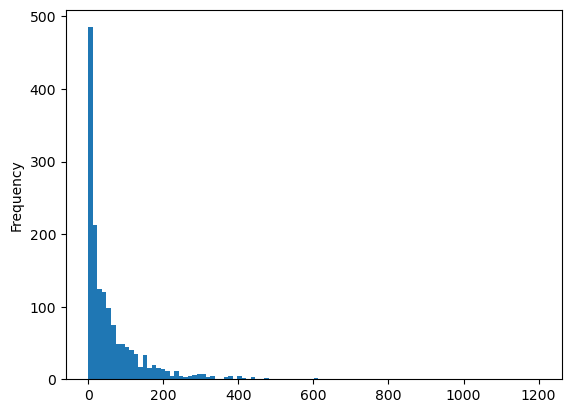

In [9]:
df.pdf_no_pages.plot(kind="hist", bins=100)

<AxesSubplot:ylabel='Frequency'>

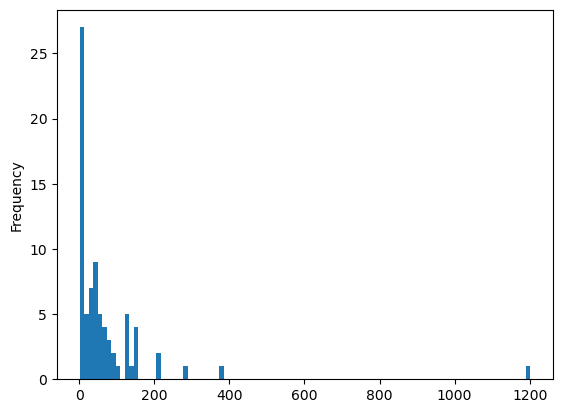

In [10]:
df[df.train_or_test=='test'].pdf_no_pages.plot(kind="hist", bins=100)

# Create Tasks for Debugging

Create a set of JSON files conforming to the expected format of the PDF parser.
- Note here that the url from the old csvs is renamed to come from the content delivery
network instead of the cpr document cache, and spaces are replaced with + to conform to pydantic model. These URLS work in practice, so fine for debugging.

In [11]:
test_df=df[df.train_or_test=='test']
test_df.rename(columns={'pdf_filename': 'document_name', 'description':'document_description'}, inplace=True)
test_df['content_type']='application/pdf'
test_df['document_slug']='xyz'
test_df_final = test_df[['id','url','document_name', 'document_description', 'content_type','document_slug']]
test_df_final['url'] = test_df_final['url'].str.replace(' ','+')
test_df_final['url'] = test_df_final['url'].str.replace('https://cpr-document-cache.s3.eu-west-2.amazonaws.com/','https://cdn.climatepolicyradar.org/')

/tmp/ipykernel_1161444/3296468352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.rename(columns={'pdf_filename': 'document_name', 'description':'document_description'}, inplace=True)
/tmp/ipykernel_1161444/3296468352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['content_type']='application/pdf'
/tmp/ipykernel_1161444/3296468352.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [12]:
import json
from pathlib import Path

in_path = Path("../data/raw")
for dict in test_df_final.to_dict(orient='records'):
    out_path=in_path/f"{str(dict['id'])}.json"
    with open(out_path,'w') as f:
        json.dump(dict, f, indent=4)
